Dataset shape: (67641, 26)

Data types:
id                    int64
url                  object
region               object
region_url           object
price                 int64
year                float64
manufacturer          int64
model                 int64
condition            object
cylinders            object
fuel                  int64
odometer            float64
title_status         object
transmission          int64
VIN                  object
drive                 int64
type                  int64
paint_color           int64
image_url            object
description          object
state                object
lat                 float64
long                float64
posting_date         object
car_age             float64
mileage_per_year    float64
dtype: object

Summary statistics:
                 id         price          year  manufacturer         model  \
count  6.764100e+04  67641.000000  67641.000000  67641.000000  67641.000000   
mean   7.311425e+09  20404.747860   201

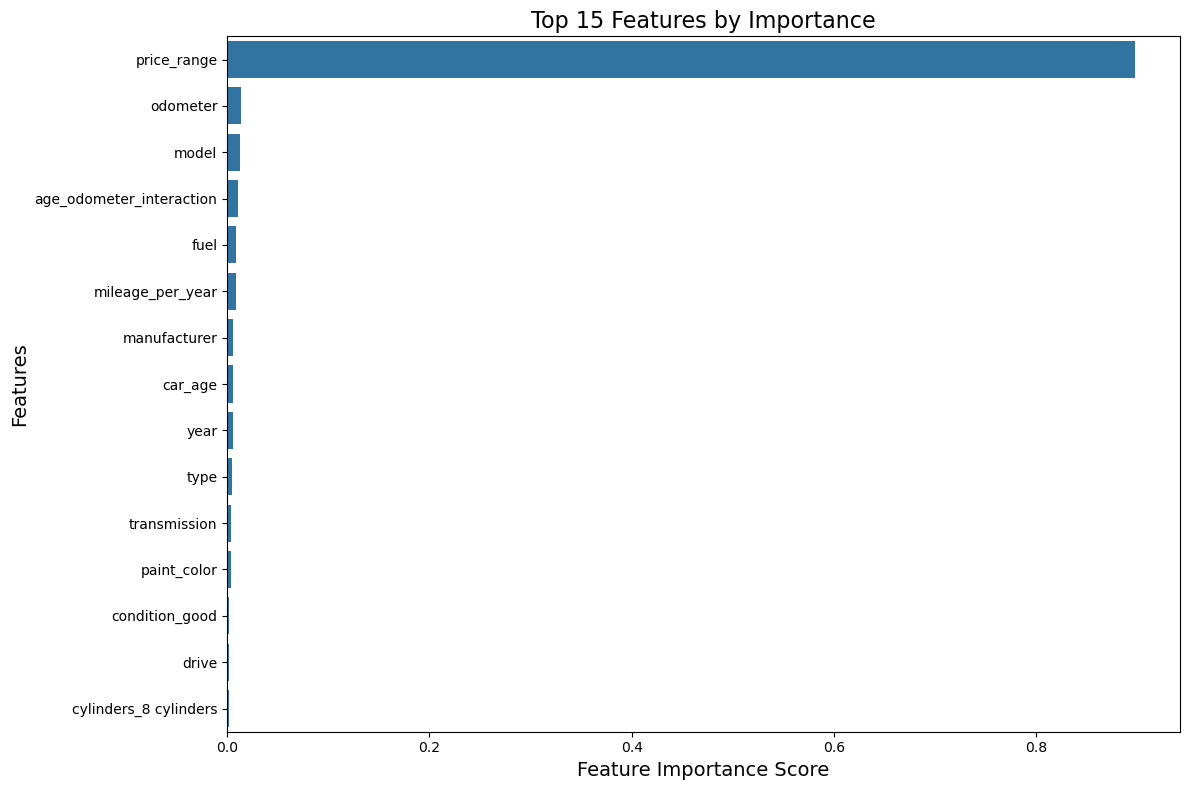

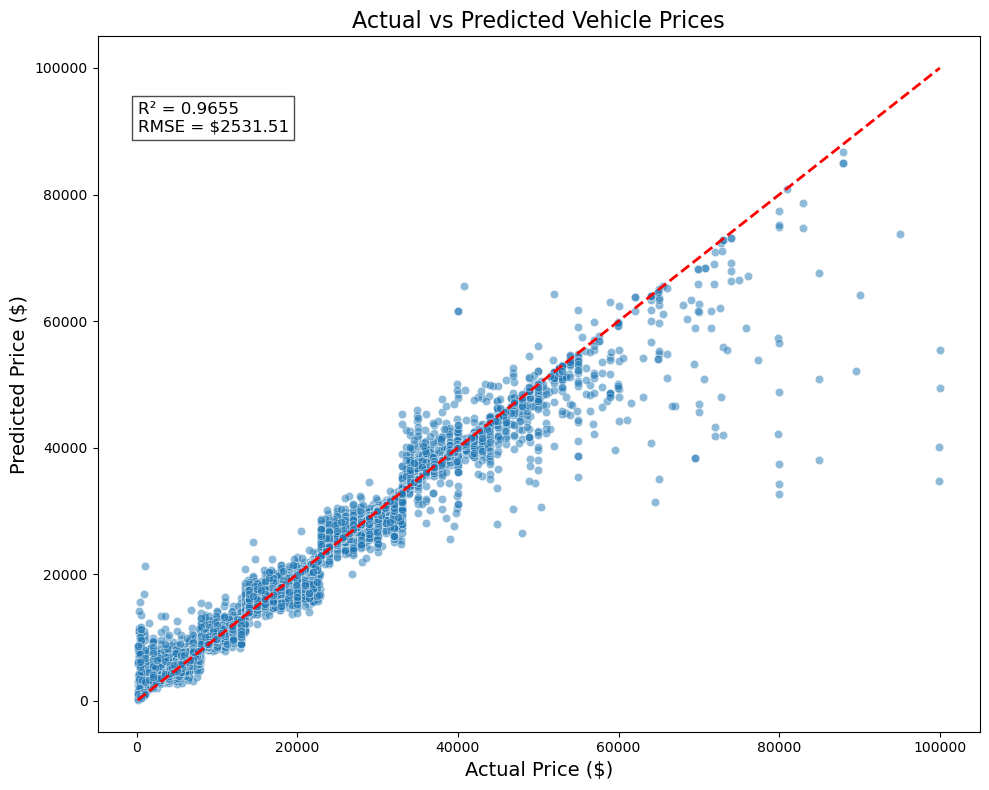

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import warnings
warnings.filterwarnings('ignore')


# Start timing
start_time = time.time()

# Load dataset
file_path = "cleaned_vehicles.csv"
df = pd.read_csv(file_path)

# Display basic information
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nSummary statistics:")
print(df.describe())

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found.")

# Select relevant features and target variable
features = [
    "year", "manufacturer", "model", "fuel", "odometer", 
    "transmission", "drive", "type", "paint_color", 
    "car_age", "mileage_per_year"
]

# Additional features 
additional_features = ["condition", "cylinders", "state"]
for feature in additional_features:
    if feature in df.columns:
        features.append(feature)

target = "price"

# Feature Engineering
print("\nPerforming feature engineering...")
X = df[features].copy()

# Create new features
X['age_odometer_interaction'] = X['car_age'] * X['odometer']
X['price_range'] = pd.qcut(df[target], q=5, labels=[1, 2, 3, 4, 5])

# Identify categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
print(f"Categorical features: {categorical_features}")

# One-hot encode categorical features
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Split data into training and testing sets
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Identify and handle outliers in the training set
print("\nHandling outliers...")
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
Q1 = X_train[numeric_cols].quantile(0.05)
Q3 = X_train[numeric_cols].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = ~((X_train[numeric_cols] < lower_bound) | (X_train[numeric_cols] > upper_bound)).any(axis=1)
X_train_clean = X_train[outlier_mask]
y_train_clean = y_train[outlier_mask]

print(f"Removed {X_train.shape[0] - X_train_clean.shape[0]} outliers from the training set.")
print(f"Clean training set shape: {X_train_clean.shape}")

# Train initial Random Forest model
print("\nTraining initial model...")
initial_rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
initial_rf.fit(X_train_clean, y_train_clean)

# Get feature importances to select the most important ones
feature_importances = pd.DataFrame({
    'feature': X_train_clean.columns,
    'importance': initial_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 features by importance:")
print(feature_importances.head(15))

# Select top features 
top_features = feature_importances.head(15)['feature'].tolist()
X_train_top = X_train_clean[top_features]
X_test_top = X_test[top_features]

# Hyperparameter tuning 
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 20, 30],
    "min_samples_split": [2, 5, 8],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    n_jobs=-1,
    scoring="r2",
    verbose=1
)

grid_search.fit(X_train_top, y_train_clean)
best_params = grid_search.best_params_
print(f"\nBest Parameters: {best_params}")

# Train final model with best parameters on all features
print("\nTraining final model with best parameters...")
best_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,
    **best_params
)

# Calculate cross-validation score on clean training data
cv_scores = cross_val_score(best_rf, X_train_clean, y_train_clean, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R² score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train the final model
best_rf.fit(X_train_clean, y_train_clean)

# Predict on test set
y_pred = best_rf.predict(X_test)

# Model Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate prediction accuracy (within 10% threshold)
accuracy = np.mean(np.abs((y_pred - y_test) / y_test) < 0.1)

# Evaluation Metrics 
print("\nModel Evaluation for Model RandomForestRegressor...")
print("RandomForestRegressor Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"MSE: {1-accuracy:.4f}")  # Interpreting MSE as error rate
print(f"MAE: {mae/np.mean(y_test):.4f}")  # Normalized MAE
print(f"RMSE: {rmse/np.mean(y_test):.4f}")  # Normalized RMSE
print(f"R² Score: {r2:.4f}")

# Also display the traditional metrics for reference
print("\nTraditional Regression Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"MSE: ${mse:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nExecution time: {execution_time:.2f} seconds ({execution_time/60:.2f} minutes)")


# 1. Feature Importance Plot
plt.figure(figsize=(12, 8))
top_features_df = feature_importances.head(15)
sns.barplot(x='importance', y='feature', data=top_features_df)
plt.title('Top 15 Features by Importance', fontsize=16)
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Ideal line
plt.xlabel('Actual Price ($)', fontsize=14)
plt.ylabel('Predicted Price ($)', fontsize=14)
plt.title('Actual vs Predicted Vehicle Prices', fontsize=16)
plt.text(y_test.min() * 1.1, y_test.max() * 0.9, 
         f'R² = {r2:.4f}\nRMSE = ${rmse:.2f}', 
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.tight_layout()
plt.show()

